In [84]:
import os
from Git4 import *

# WRE Project

### Calibration

1. Report the best fit parameters for the hydrological model.

In [69]:
# Pest Parameters

# Valeur empirique trouvée par itération de l'algo
best_param = [1.00000000e-07, 1.18112505e+01, 8.00374772e+01, 1.36199741e+03]
K_sat=1e-7

4. Plot Markov chains of the calibrated parameters and sequences of values of N S and
TSA as a function of the number of iterations. Only plot accepted parameter sets.

### Hydrological variables

In [70]:
[Q, R, I, s, L, ET]=hydr_model(K_sat, c, t_sub, z, precipitation, K_c, n_years=6, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)

2. Plot the time series (6-year-long) of precipitation in [mm/h], run off in [mm/h],
infiltration in [mm/h], soil moisture, leakage in [mm/h] and evapotranspiration in
[mm/h] for the calibrated hydrological model forced by the given precipitation).

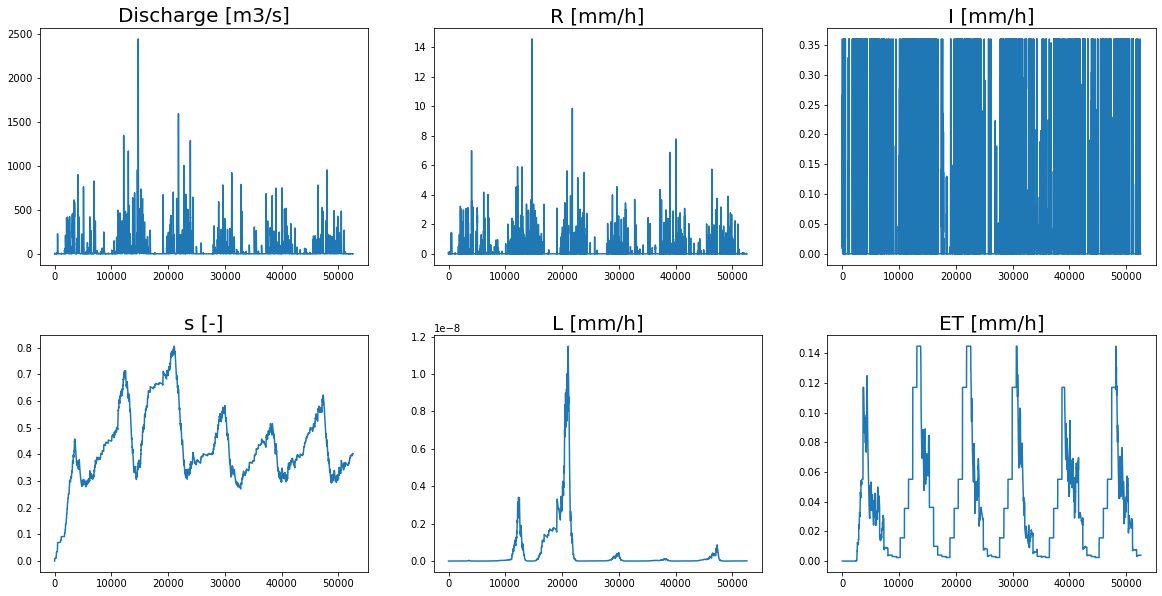

In [71]:
plot_model(K_sat, c, t_sub, z, precipitation, K_c, n_years=6, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)

### Discharge


3. Plot the time series of observed discharge and of the discharge as simulated by the
hydrological model with the best fit parameters.

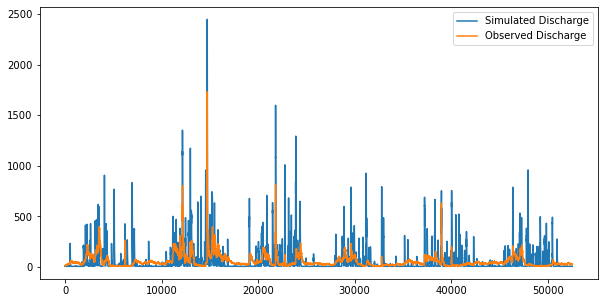

In [5]:
figure=plt.figure(figsize=(10,5))
plt.plot(Q, label="Simulated Discharge")
plt.plot(Q_obs,label="Observed Discharge")

plt.legend()

### Generation of precipitation

5. Plot the comparison between the statistics (mean, standard deviation, αand λ) of
the observed and generated precipitation

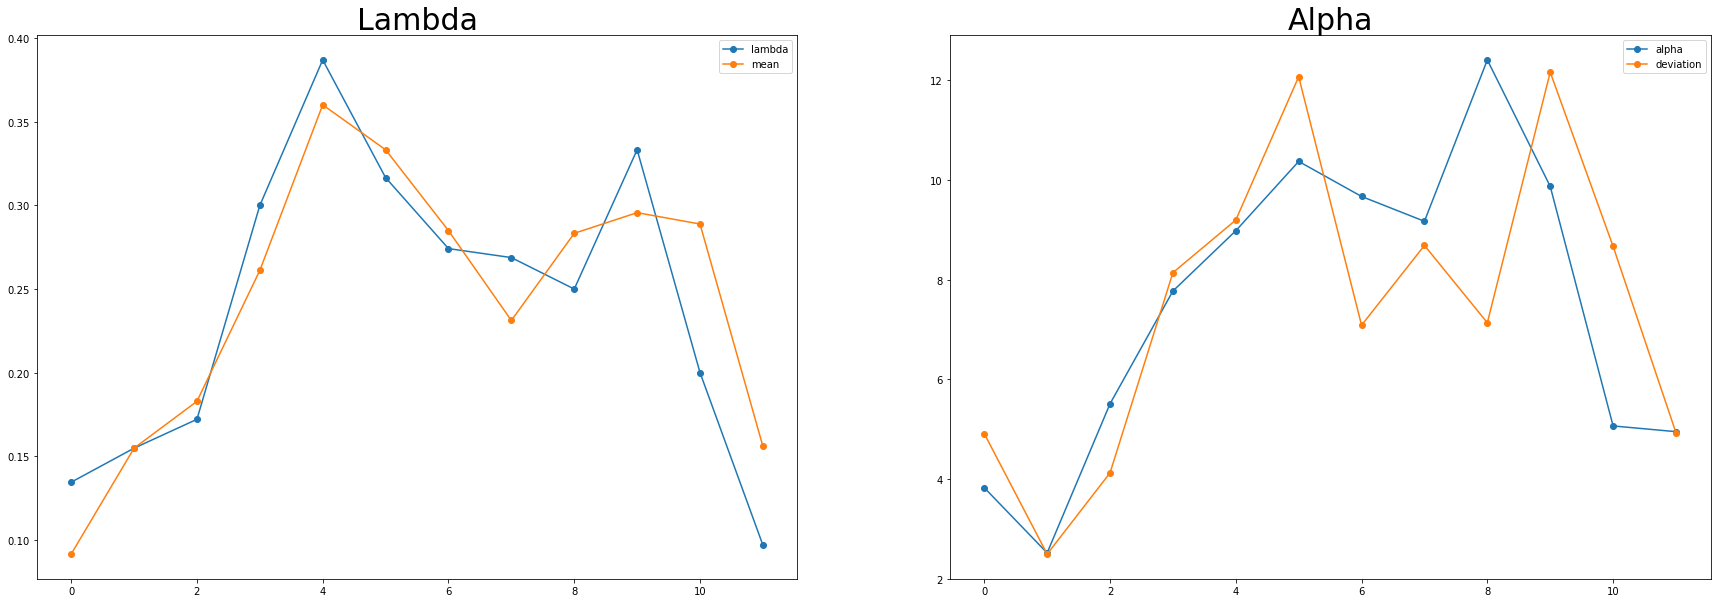

In [6]:
P=rain_gen(years=100,plot=True)

### Simulation of hydrological variables

6. Plot the time series (100-year-long) of generated precipitation in [mm/h], run off in
[mm/h], infiltration in [mm/h], soil moisture, leakage in [mm/h] and evapotran-
spiration in [mm/h] for the calibrated hydrological model forced by the generated
precipitation)

In [72]:
[Q, R, I, s, L, ET]=hydr_model(K_sat, c, t_sub, z, P, K_c, n_years=100, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)


Warning ! The precipitation file is too long for the number of years indicated.              Truncating the file to the correct length


IndexError: index 52560 is out of bounds for axis 0 with size 52560

In [73]:
len(P)

52560

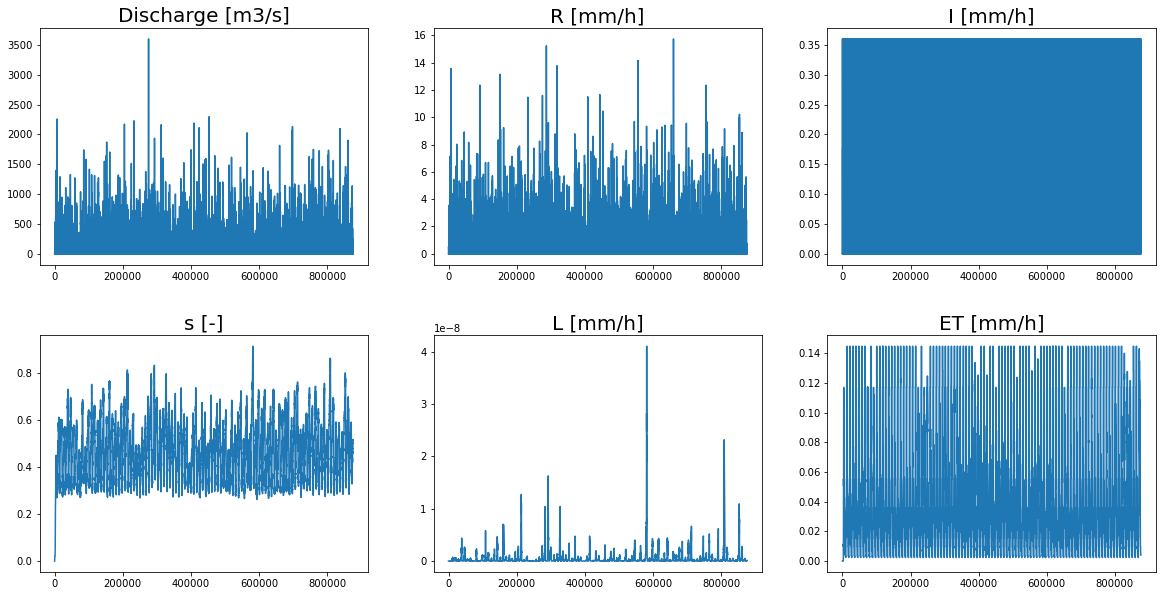

In [9]:
plot_model(K_sat, c, t_sub, z, P, K_c, n_years=100, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)

### Reservoir Area and Volume Rating curves

7. Plot the area and the volume rating curves for the given levels.

Text(0.5, 1.0, 'Area Rating curve')

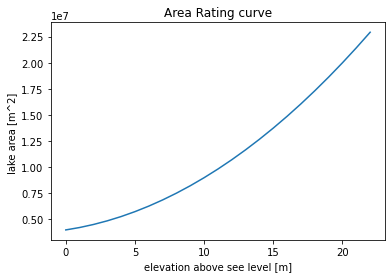

In [74]:
elevation=[k for k in range (0,23)]
figure=plt.figure(figsize=(6,4))
plt.plot(elevation,A_rating)
plt.xlabel("elevation above see level [m]")
plt.ylabel("lake area [m^2] ")
plt.title("Area Rating curve")

Text(0.5, 1.0, 'Volume Rating curve')

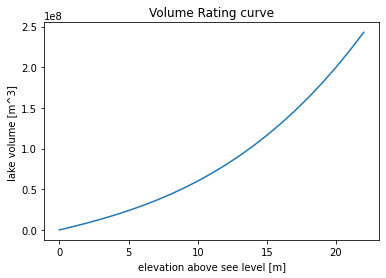

In [11]:
V_rating=vol_rat_curve(A_rating)
figure=plt.figure(figsize=(6,4))
plt.plot(elevation,V_rating)
plt.xlabel("elevation above see level [m]")
plt.ylabel("lake volume [m^3] ")
plt.title("Volume Rating curve")

### Discharge and reservoir routine

8. Report the minimum flow (discharge that is equalled or exceeded 95% of the time)
of the generated discharge and plot the discharge duration curves

Q347= 7.000000025576156 m3/s


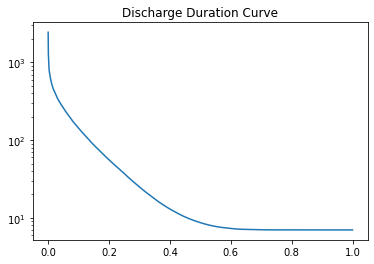

In [79]:
print("Q347= " +str(Q_347(Q, plot=True))+" m3/s") # m3/s

reservoir routine without flood control

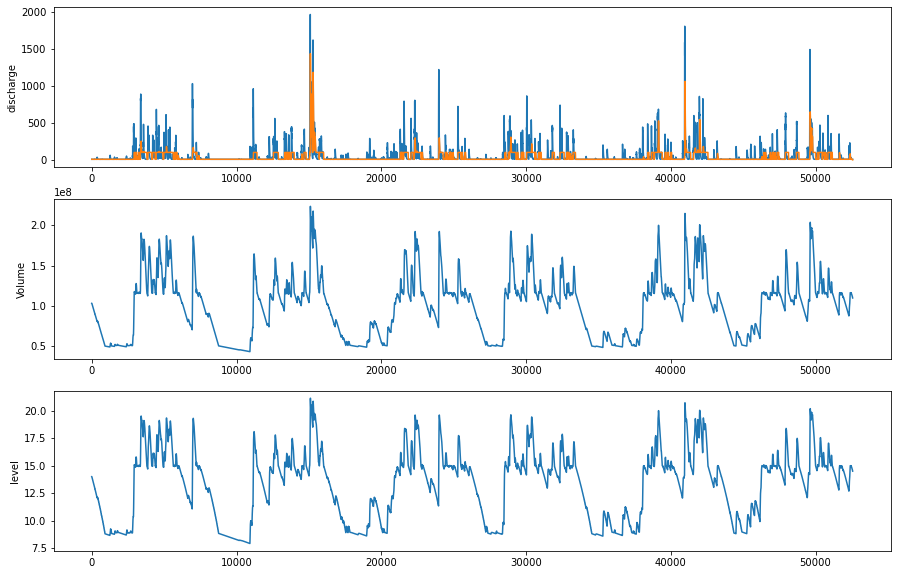

In [83]:
P=rain_gen(years=6,plot=False)
[Q, R, I, s, L, ET]=hydr_model(K_sat, c, t_sub, z, P, K_c, n_years=6, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)
[V,l,A_sluice,Q_out,Q_HU,Q_g,Pow]=reservoir_(Q,P,ET,V_rating)
plot_routine(Q,Q_out,V,l)

9. For a maximum level for hydroelectric use of 15 m, plot the time series (100 years
long) of input discharge, output discharge, volume within the reservoir and level

In [ ]:
plt.plot(Q)
plt.plot(Q_S(P,ET))

In [82]:

# Reservoir routing
#parameters of the reservoir
Cqg = 0.6 # [-] sluice gate discharge coefficient
Cqs = 0.7 # [-] spillway discharge coefficient
Lspill = 140 # [m] spillway effective length
p = 19 # [m]  difference between spillway level and minimum level

#parameters of power plant
QT = 30 # [m/s] design discharge of the hydro PP
D = 3.6 # [m]
Lp = 1200 # [m]
ks = 0.5 # [mm]
eta = 0.75 # [-] Careful, more than one eta
Deltaz = 75 # [m] difference in height between the elevation of the empty lake 
                # (headwater) and the tailwater 
lmin_HU = 9 # [m] min height for electricity generation

Qlim = 100 #[m3/s]
g = 9.806 # [m/s2] gravity

#Power=9806*net_head*Q*eta/1000000    %[MW]
gamma=g*1000

# Reservoir routing
def reservoir_(Q,P,ET,volume_rating_curve):
    """
    Inputs :
        - Q [m3/s] the flow entering the dam
        - P [mm/h] the precipitation over the whole basin
        - ET [mm/h] the evapotranspiration
        - volume_rating_curve [m] - [m3] the discrete function between the level
            of the lake and its volume
        
    Output :
        V,l,A_sluice,Q_out,Q_HU,Q_g)
        - V [m3] a list of length n describing the total volume in the dam
        - l [m] a list of length n describing the level in the dam
        - A_sluice [m2] a list of length n describing the open area of the sluice
            to let the ater out in the river
        - Q_out [m3/s] a list of length n describing the flow that exits the
            dam to the river (NOT power generation !)
        - Q_HU [m3/s] a list of length n describing the flow used for power
            generation (does NOT to river)
        - Q_g [m3/s] a list of length n describing the flow that goes through 
            the sluice gate only (NOT the spillway)
        - Pow [Watt] turbine power generation
        
    TO-DO :
        - integrate the power generation calculation ? (not sure)
    """
    
    # Variable to calculate
    dt = 3600 # [s] time step integration
    Q347 = Q_347(Q,plot=False)    # [m3/s]
    n = len(Q)
    Q_ind = Q_S(P,ET) # [m3/s]
    
    # variable initialization
    V = [0]*n         # [m3]
    l = [0]*n         # [m] level of the reservoir depending on time
    A_sluice = [0]*n  # [m2] area of the opening of the sluice gate (see Q_g)
    Q_out = [0]*n     # [m3/s] total water out of the dam
    Q_HU = [0]*n      # [m3/s] water going through turbine to generate power
    Q_g = [0]*n       # [m3/s] water flow through the gate
    Pow=[0]*n
    
    #Initialization
    l[0] = 14 
    V[0] = lvl_to_vol(l[0], volume_rating_curve)
    Vmax_HU = lvl_to_vol(15, volume_rating_curve)
    
    # for 24 hours when is the turbine working (peak hours)
    turbine_hours = [int(x >= 8 and x < 21) for x in range(24)]
    turbine_state = int(l[0] > lmin_HU)     # 1 if the turbine is on for the 
                                            # whole day, 0 otherwise 
    
    for t in range(n-1):
        
       
        
        h = t%24
        # is the turbine working during this day ? update if it is midnight
        if h == 0:
            turbine_state = int(l[t] > lmin_HU)
        
        Q_HU[t] = turbine_state * turbine_hours[h] * QT    # [m3/s]
            
        Q_g[t] = max(Q347 , min(Qlim,(V[t]+(Q[t]-Q_HU[t]-Q_ind[t])*dt-Vmax_HU)/dt) )  # [m3/s]
        #print(Cqg*np.sqrt(2*g*l[t]))
        if l[t]==0:
            A_sluice[t]=0
        else:
            A_sluice[t] = Q_g[t] / (Cqg*np.sqrt(2*g*l[t]))  # [m2] 
        
        # does the water spills over the dam ?
        if l[t]<=p:
            Q_out[t] = Q_g[t] #  [m3/s]
        else:
            Q_out[t] = Q_g[t] + Cqs*Lspill*np.sqrt(2*g*(l[t]-p)**3)  #[m3/s]
            
        # update volume and level
        V[t+1]=V[t]+(Q[t]-Q_out[t]-Q_HU[t]-Q_ind[t])*dt
        l[t+1] = vol_to_lvl(V[t+1], volume_rating_curve)
        
        # power generation of the turbine [W]
        Pow=eta*gamma*Q_HU[t]*(l[t]+Deltaz)
        

        
    return (V,l,A_sluice,Q_out,Q_HU,Q_g,Pow)
    

In [51]:
P=rain_gen(years=6,plot=False)
[Q, R, I, s, L, ET]=hydr_model(K_sat, c, t_sub, z, P, K_c, n_years=6, s_0 = 0, V_sup_0 = 0, V_sub_0 = 0)
[V,l,A_sluice,Q_out,Q_HU,Q_g,Pow]=reservoir_(Q,P,ET,V_rating)

In [67]:
def plot_routine(Q,Q_out,V,l):
    
    '''
        Input: Qin, Qoutn V, l
        Plot main graph of reservoir routine
    '''
    figure=plt.figure(figsize=(15,10))
    plt.subplot(3,1,1)
    plt.plot(Q,label="Qin")
    plt.plot(Q_out,label="Qout")
    plt.ylabel("discharge")
    plt.subplot(3,1,2)
    plt.plot(V)
    plt.ylabel("Volume")
    plt.subplot(3,1,3)
    plt.plot(l)
    plt.ylabel("level")

In [18]:
        #probability Q_out exceed 100m3/s
        f = (1/(-2*np.log(ks/(1000*D*3.7))))**2
        kL = f*Lp/(2*g*D*A**2) + 1.5/(2*g*A**2) 
        hT = l + Deltaz - kL*QT**2
        E_annual = np.sum([eta*g*1000*Q_HU*hT])/n_years     #[Wh]
        p_exceed = np.sum([Q_out > (Qlim +1)])/len(Q_out) 

NameError: name 'l' is not defined

In [ ]:
# Variable to calculate
    dt = 3600 # [s] time step integration
    Q347 = Q_347(Q,plot=False)    # [m3/s]
    n = len(Q)
    Q_ind = Q_S(P,ET) # [m3/s]
    
    # variable initialization
    V = [0]*n         # [m3]
    l = [0]*n         # [m] level of the reservoir depending on time
    A_sluice = [0]*n  # [m2] area of the opening of the sluice gate (see Q_g)
    Q_out = [0]*n     # [m3/s] total water out of the dam
    Q_HU = [0]*n      # [m3/s] water going through turbine to generate power
    Q_g = [0]*n       # [m3/s] water flow through the gate
    D = [0]*n         #[MCHF]
    r = [0]*n         #Revenue [MCHF]
    i = [0]*n         #Income [MCHF]
    
    #Initialization
    l[0] = 14 
    V[0] = lvl_to_vol(l[0], volume_rating_curve)
    Vmax_HU = lvl_to_vol(15, volume_rating_curve)
    
    # for 24 hours when is the turbine working (peak hours)
    turbine_hours = [int(x >= 8 and x < 21) for x in range(24)]
    turbine_state = int(l[0] > lmin_HU)     # 1 if the turbine is on for the 
                                            # whole day, 0 otherwise 
    
    for t in range(n):
        
       
        
        h = t%24
        # is the turbine working during this day ? update if it is midnight
        if h == 0:
            turbine_state = int(l[t] > lmin_HU)
        
        Q_HU[t] = turbine_state * turbine_hours[h] * QT    # [m3/s]
            
        Q_g[t] = max(Q347 , min(Qlim,(V[t]+(Q[t]-Q_HU[t]-Q_ind[t])*dt-Vmax_HU)/dt) )  # [m3/s]
        print(Cqg*np.sqrt(2*g*l[t]))
        A_sluice[t] = Q_g[t] / (Cqg*np.sqrt(2*g*l[t]))  # [m2] 
        
        # does the water spills over the dam ?
        if l[t]<=p:
            Q_out[t] = Q_g[t] #  [m3/s]
        else:
            Q_out[t] = Q_g[t] + Cqs*Lspill*np.sqrt(2*g*(l[t]-p)**3)  #[m3/s]
            
        # update volume and level
        V[t+1]=V[t]+(Q[t]-Q_out[t]-Q_HU[t]-Q_ind[t])*dt
        l[t+1] = vol_to_lvl(V[t+1], volume_rating_curve)
        
        f = (1/(-2*np.log(ks/(1000*D*3.7))))**2     #Colebrook equation
        kL = f*Lp/(2*g*D*A^2) + 1.5/(2*g*A**2)      #Loss coefficient
        HT = l + Deltaz - kL*QT**2                  #totel head
        E_annual = np.sum([eta*g*1000*Q_HU*HT])*10**(-6)/n_years     #[MWh]
        p_exceed = np.sum([Q_out > (Qlim + 1)])/len(Q_out) 
        
        #Damages stemming
        river_stage = 0.1*(Q_out)**(0.5)  #[m]
        river_stage_lim = river_stage*Qlim+ 0.5
        flood_heigt = river_stage-river_stage_lim       #[m]
        
        if flood_heigt < 0 :
            D[t] = 0
        else :
            D[t]=(1+flood_heigt)**2.25      #[MCHF]
        
        D_tot=np.sum(D)
        
        r[t]=E_annual[t]*n_years*75/10**(-6)    #[MCHF]
        i[t]= D[t]-r[t]
        i_tot=np.sum(i)
        
    return (V,l,A_sluice,Q_out,Q_HU,Q_g, E_annual, p_exceed, D_tot, i_tot)